# Speaker Identification

In [1]:
!pip3 install tensorflow==2.8.0
!pip3 install tensorflow-io==0.25.0

In [2]:
import sys
import os
import random
from pathlib import Path
from typing import Tuple

import librosa
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib import cm

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("TensorFlow IO version:", tfio.__version__)
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

TensorFlow version: 2.8.0
TensorFlow IO version: 0.25.0
True


In [3]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR='/content/drive/MyDrive/College/Research/Linh_2023_Research'

DATASET_PATH=ROOT_DIR+'/test_data/vox'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset preparation
[Keras Speaker Recognition](https://keras.io/examples/audio/speaker_recognition_using_cnn/)

In [4]:
SAMPLING_RATE = 16000
N_MFCC = 13
BATCH_SIZE = 128
SHUFFLE_SEED = 11
TRAIN_VALID_SPLIT = 0.2
EPOCHS = 100

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

def audio_to_mfcc(audio):
    audio = tf.squeeze(audio, axis=-1)
    # Convert the audio to MFCC
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        N_MFCC, num_spectrogram_bins, SAMPLING_RATE, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first N_MFCC
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :N_MFCC]
    print(mfccs)

    return mfccs

In [22]:
class_names = os.listdir(DATASET_PATH)
audio_paths = []
labels = []
random.shuffle(class_names)
for label, name in enumerate(class_names):
    if label > 4: break
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(TRAIN_VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

# Transform audio wave to the frequency domain using `audio_to_mfcc`
train_ds = train_ds.map(
    lambda x, y: (audio_to_mfcc(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_mfcc(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Processing speaker id10009
Processing speaker id10612
Processing speaker id10410
Processing speaker id10156
Processing speaker id10743
Found 466 files belonging to 395 classes.
Using 373 files for training.
Using 93 files for validation.
Tensor("strided_slice:0", shape=(None, 59, 13), dtype=float32)
Tensor("strided_slice:0", shape=(None, 59, 13), dtype=float32)


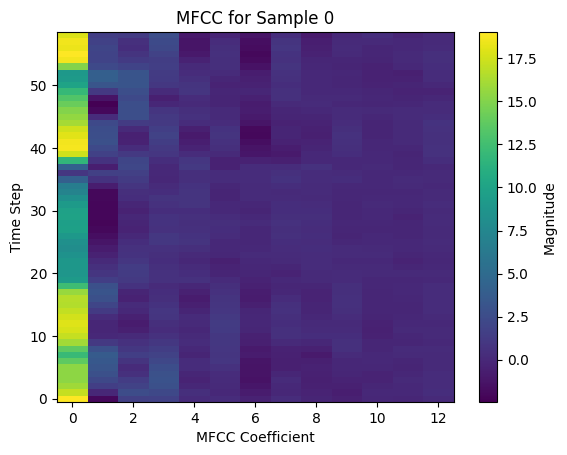

In [6]:
for i, data in enumerate(train_ds):
    if i > 0: break
    x, y = data
    # Extract the chosen sample
    selected_sample_np = x[i].numpy()

    # Display the MFCC for the selected sample
    plt.imshow(selected_sample_np, cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'MFCC for Sample {i}')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Time Step')
    plt.colorbar(label='Magnitude')
    plt.show()


## Model

MFCC

FFT (focus on low freq) ---> CNN (max pool in one direction)

Is speaker unique in consonant or vowel?



In [23]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return x  # Remove MaxPooling1D layer


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((59, N_MFCC), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 59, 13)]     0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 59, 16)       640         ['input[0][0]']                  
                                                                                                  
 activation_13 (Activation)     (None, 59, 16)       0           ['conv1d_19[0][0]']              
                                                                                                  
 conv1d_20 (Conv1D)             (None, 59, 16)       784         ['activation_13[0][0]']          
                                                                                            

## Training

`fit()` is for training the model with the given inputs (and corresponding training labels).

`evaluate()` is for evaluating the already trained model using the validation (or test) data and the corresponding labels. Returns the loss value and metrics values for the model.

`predict()` is for the actual prediction. It generates output predictions for the input samples.

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
3/3 [==============================] - 47s 6s/step - loss: 4.3440 - accuracy: 0.2654 - val_loss: 4.7009 - val_accuracy: 0.2043
Epoch 2/100
3/3 [==============================] - 6s 1s/step - loss: 3.5277 - accuracy: 0.1769 - val_loss: 2.2867 - val_accuracy: 0.3763
Epoch 3/100
3/3 [==============================] - 10s 3s/step - loss: 2.1316 - accuracy: 0.4182 - val_loss: 1.8960 - val_accuracy: 0.3763
Epoch 4/100
3/3 [==============================] - 5s 1s/step - loss: 1.6970 - accuracy: 0.3432 - val_loss: 1.6174 - val_accuracy: 0.2688
Epoch 5/100
3/3 [==============================] - 8s 2s/step - loss: 1.5133 - accuracy: 0.4316 - val_loss: 1.5247 - val_accuracy: 0.3763
Epoch 6/100
3/3 [==============================] - 5s 1s/step - loss: 1.4499 - accuracy: 0.4424 - val_loss: 1.4816 - val_accuracy: 0.4086
Epoch 7/100
3/3 [==============================] - 8s 2s/step - loss: 1.3141 - accuracy: 0.4584 - val_loss: 1.4177 - val_accuracy: 0.3978
Epoch 8/100
3/3 [===============

## Evaluate

In [25]:
print(model.evaluate(valid_ds))

3/3 [==============================] - 2s 195ms/step - loss: 0.9672 - accuracy: 0.6559
[0.967174232006073, 0.6559139490127563]


In [10]:
predictions = model.predict(valid_ds)

for data, true_labels in valid_ds:
    predicted_labels = np.argmax(model.predict(data), axis=-1)

    for true_label, predicted_label in zip(true_labels.numpy(), predicted_labels):
        print(f'True Label: {true_label}, Predicted Label: {predicted_label}')

True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 4, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 3
True Label: 2, Predicted Label: 2
True Label: 4, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 3
True Label: 1, Predicted Label: 3
True Label: 2, Predicted Label: 2
True Label: 3, Predicted Label: 1
True Label: 4, Predicted Label: 4
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 3
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 3
True Label: 0, Predicted Label: 4
True Label: 3, Predicted Label: 3
True Label: 2, Predicted Label: 2
True Label: 4, Predicted Label: 2
True Label: 3, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 4, Predicted Label: 4
True Label: 3, Predicted Label: 2
True Label: 3,